## softmax 简洁实现
例子: 对 mnist 数据集中的图片进行分类预测

### 导入一些库

In [26]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
import time
from IPython.core import display

### 读取数据集

In [27]:
def get_dataloader_workers():
    """设定工作进程数"""
    return 0

In [28]:
def load_data_mnist(batch_size, resize=None):
    """下载MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [29]:
batch_size = 10
train_iter, test_iter = load_data_mnist(batch_size)

### 初始化模型参数

In [30]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 定义优化算法

In [31]:
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

### 定义损失函数

In [32]:
loss = nn.CrossEntropyLoss(reduction='none')

### 训练结果精度评估

In [33]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = (y_hat.type(y.dtype) == y)
    return float(cmp.type(y.dtype).sum())

In [34]:
class Accumulator:
    """在 n 个变量上进行累加的一个累加器"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        selfdata = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [35]:
def evaluate_accuracy(net, data_iter):
    """计算在特定数据集上的模型精度"""
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] # 成功预测的数 / 预测总数

### 开始训练

训练可视化工具

In [36]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
            """Set the axes for matplotlib."""
            axes.set_xlabel(xlabel)
            axes.set_ylabel(ylabel)
            axes.set_xscale(xscale)
            axes.set_yscale(yscale)
            axes.set_xlim(xlim)
            axes.set_ylim(ylim)
            if legend:
                axes.legend(legend)
            axes.grid()
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        # 初始化参数
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

训练函数

In [37]:
def train_epoch_softmax(net, train_iter, loss, updater):
    """训练模型的一个迭代周期""" 
    # 将模型调整成训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练精准度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
    # 返回训练损失和训练精度
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [38]:
def train_softmax(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                         legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_softmax(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

训练 num_epochs 个周期

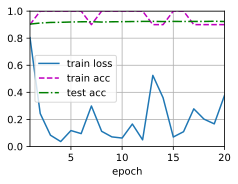

In [39]:
num_epochs = 20
train_softmax(net, train_iter, test_iter, loss, num_epochs, trainer)

### 使用模型进行预测

In [40]:
def get_mnist_labels(labels):
    """返回MNIST数据集的文本标签"""
    return [str(int(i)) for i in labels]

In [41]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

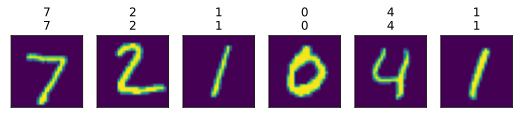

In [42]:
def predicet_minst(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predicet_minst(net, test_iter)